In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('energy_cleaned.csv')

In [3]:
# 1. Filter rows with missing target
df = df.dropna(subset=['BESG ESG Score'])

In [4]:
# 2. Define feature columns (exclude identifiers and target)
excluded_columns = ['Company', 'Ticker', 'Year', 'Revenue', 'Net Income, Adj', 'Margin %', 'EPS, Adj', 'Market Cap ($M)',
                    'BESG ESG Score','BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score']
feature_columns = [col for col in df.columns if col not in excluded_columns]

In [5]:
# 3. Handle missing data
df[feature_columns] = df.groupby('Ticker')[feature_columns].transform(
    lambda x: x.ffill().bfill().fillna(0)
)

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_44339/3054525727.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.ffill().bfill().fillna(0)


In [6]:
# Remove rows with #N/A Requesting Data... from any column
df = df.replace('#N/A Requesting Data...', np.nan)

In [7]:
# 4. One-hot encode categorical variables

# Auto-classify columns with 'yes' and 'no' as binary
for col in df.columns:
    if df[col].isin(['yes', 'no']).all():
        df[col] = df[col].map({'yes': 1, 'no': 0})

# One hot encode Market Cap Category - ensure binary columns for each category
df = pd.get_dummies(df, columns=['Market Cap Category'])

In [8]:
feature_columns = [col for col in df.columns if col not in excluded_columns]

In [9]:
# Replace all values that cannot be converted to float with NaN
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

In [10]:
# Clean up columns

# Drop columns when not enough data
df_clean = df.dropna(axis=1, thresh=0.75*len(df))

# Drop columns with only one unique value
df_clean = df_clean.drop(columns=df_clean.columns[df_clean.nunique() == 1])

df_clean = df_clean.dropna()

df_clean.shape

(365, 97)

In [11]:
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        print(col, df_clean[col].isnull().sum())

In [12]:
# Change feature_columns to include new one-hot encoded columns
feature_columns = [col for col in df_clean.columns if col not in excluded_columns]

In [13]:
for col in feature_columns:
    print(col, df_clean[col].dtype)

ESG Disclosure Score float64
Environmental Disclosure Score float64
Social Disclosure Score float64
Governance Disclosure Score float64
Nitrogen Oxide Emissions float64
VOC Emissions float64
Particulate Emissions float64
Sulphur Dioxide / Sulphur Oxide Emissions float64
GHG Scope 2 Location-Based float64
Carbon per Unit of Production float64
Energy Per Unit of Production float64
Community Spending float64
Pct Women in Middle and or Other Management float64
Pct Women in Workforce float64
Fatalities - Employees float64
Fatalities - Contractors float64
Fatalities - Total float64
Lost Time Incident Rate - Employees float64
Lost Time Incident Rate - Contractors float64
Lost Time Incident Rate - Workforce float64
Total Recordable Incident Rate - Employees float64
Total Recordable Incident Rate - Contractors float64
Total Recordable Incident Rate - Workforce float64
Number of Contractors float64
Employee Turnover Pct float64
Years Auditor Employed float64
Size of Audit Committee float64
Numbe

In [14]:
# 5. Normalize features
target_columns = ['BESG ESG Score']

scaler = StandardScaler()
df_clean[feature_columns] = scaler.fit_transform(df_clean[feature_columns])
df_clean[target_columns] = scaler.fit_transform(df_clean[target_columns])

In [15]:
# 5. Sequence creation function
def create_sequences(data, window_size=2):
    X, y = [], []
    for company in data["Ticker"].unique():
        company_data = data[data["Ticker"] == company].sort_values("Year")
        # Allow non-consecutive years
        if len(company_data) >= window_size + 1:
            for i in range(len(company_data) - window_size):
                seq = company_data.iloc[i:i+window_size][feature_columns]
                target = company_data.iloc[i+window_size]["BESG ESG Score"]
                # Allow partial sequences if >50% features present
                if seq.isnull().sum().sum() < (seq.size * 0.5) and not pd.isnull(target):
                    X.append(seq.values)
                    y.append(target)
    return np.array(X), np.array(y)

In [16]:
X, y = create_sequences(df_clean, window_size=2)

print(f"Generated sequences: {len(X)}")

Generated sequences: 254


In [17]:
X.shape, y.shape

((254, 2, 89), (254,))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((203, 2, 89), (51, 2, 89), (203,), (51,))

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=True, kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False, kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.5))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 128)         │       111,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,089 (629.25 KB)

 Trainable params: 161,089 (629.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Convert the input data to numeric type
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

early_stop = EarlyStopping(monitor='val_mae', patience=500, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=5000,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 1.0085 - mae: 0.7928 - val_loss: 0.8451 - val_mae: 0.7175
Epoch 2/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0351 - mae: 0.8210 - val_loss: 0.8306 - val_mae: 0.7110
Epoch 3/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0136 - mae: 0.7937 - val_loss: 0.8170 - val_mae: 0.7046
Epoch 4/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0190 - mae: 0.8061 - val_loss: 0.8025 - val_mae: 0.6977
Epoch 5/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0289 - mae: 0.8052 - val_loss: 0.7887 - val_mae: 0.6910
Epoch 6/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9348 - mae: 0.7586 - val_loss: 0.7751 - val_mae: 0.6843
Epoch 7/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9911 - mae: 0.7930 - val_loss: 0.7619 - val_mae: 0.6777
Epoch 8/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9092 - mae: 0.7617 - val_loss: 0.7487 - val_mae: 0.6711
Epoch 9/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.03

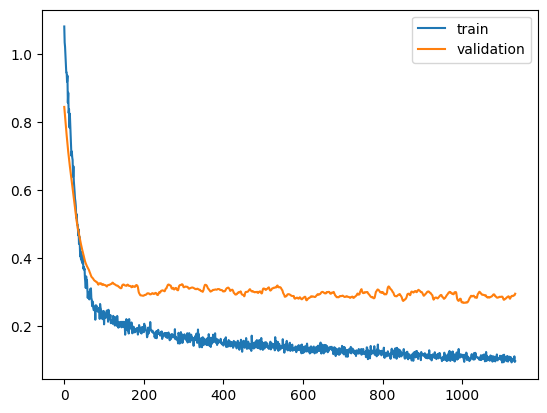

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

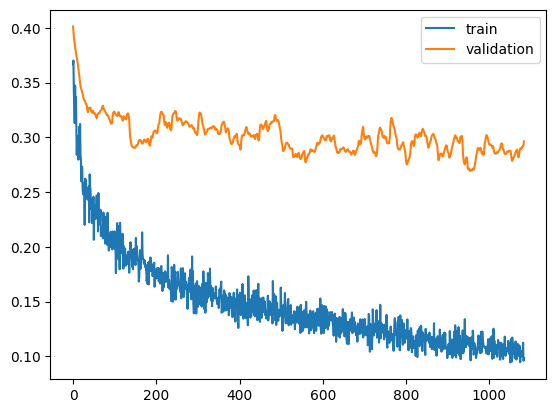

In [24]:
# Plot after 200 epochs
plt.plot(history.history['loss'][50:], label='train')
plt.plot(history.history['val_loss'][50:], label='validation')
plt.legend()
plt.show()

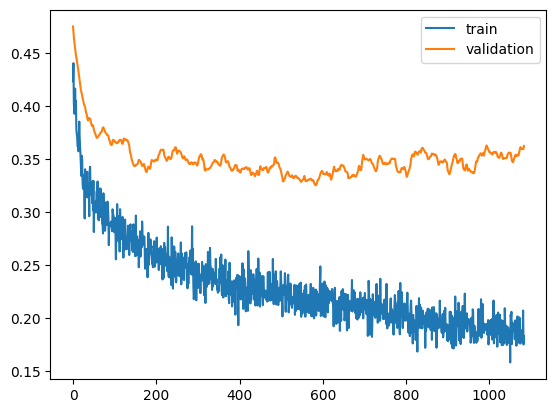

In [25]:
# Plot MAE
plt.plot(history.history['mae'][50:], label='train')
plt.plot(history.history['val_mae'][50:], label='validation')
plt.legend()
plt.show()

In [26]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2520 - mae: 0.3243
Test MAE: 0.34


In [27]:
import shap

# 1. Flatten data
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat  = X_test.reshape((X_test.shape[0], -1))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# 2. Define the predict function that reshapes back to (samples, timesteps, features)
def predict_fn(flat_data):
    reshaped_data = flat_data.reshape((flat_data.shape[0], X_train.shape[1], X_train.shape[2]))
    return model.predict(reshaped_data).ravel()

In [29]:
# 3. Create a mapping of feature indices to meaningful names
n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]
feature_names = [f"{col} (t-{t})" for t in range(n_timesteps) for col in feature_columns]

In [30]:
# 4. Initialize KernelExplainer with a small background
background = X_train_flat[:50]
explainer = shap.KernelExplainer(predict_fn, background)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [31]:
# 5. Compute SHAP values for the entire test set
shap_values = explainer.shap_values(X_test_flat)

  0%|          | 0/51 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


  2%|▏         | 1/51 [00:06<05:20,  6.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


  4%|▍         | 2/51 [00:13<05:28,  6.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  6%|▌         | 3/51 [00:18<04:56,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  8%|▊         | 4/51 [00:24<04:45,  6.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 10%|▉         | 5/51 [00:30<04:28,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 12%|█▏        | 6/51 [00:35<04:16,  5.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 14%|█▎        | 7/51 [00:41<04:07,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 16%|█▌        | 8/51 [00:46<03:57,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 18%|█▊        | 9/51 [00:51<03:51,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 20%|█▉        | 10/51 [00:57<03:42,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 22%|██▏       | 11/51 [01:02<03:32,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 24%|██▎       | 12/51 [01:07<03:25,  5.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 25%|██▌       | 13/51 [01:12<03:17,  5.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 27%|██▋       | 14/51 [01:17<03:11,  5.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 29%|██▉       | 15/51 [01:22<03:06,  5.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 31%|███▏      | 16/51 [01:27<03:00,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 33%|███▎      | 17/51 [01:33<02:57,  5.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 35%|███▌      | 18/51 [01:38<02:51,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 37%|███▋      | 19/51 [01:43<02:49,  5.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 39%|███▉      | 20/51 [01:49<02:43,  5.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 41%|████      | 21/51 [01:54<02:36,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 993us/step


 43%|████▎     | 22/51 [01:59<02:29,  5.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step  


 45%|████▌     | 23/51 [02:04<02:23,  5.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 47%|████▋     | 24/51 [02:09<02:18,  5.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 49%|████▉     | 25/51 [02:14<02:15,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step  


 51%|█████     | 26/51 [02:19<02:08,  5.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 53%|█████▎    | 27/51 [02:25<02:04,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 55%|█████▍    | 28/51 [02:30<01:58,  5.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step  


 57%|█████▋    | 29/51 [02:35<01:53,  5.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step  


 59%|█████▉    | 30/51 [02:40<01:47,  5.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 61%|██████    | 31/51 [02:46<01:45,  5.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 63%|██████▎   | 32/51 [02:51<01:40,  5.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step  


 65%|██████▍   | 33/51 [02:56<01:33,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 67%|██████▋   | 34/51 [03:02<01:33,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 69%|██████▊   | 35/51 [03:08<01:32,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 71%|███████   | 36/51 [03:14<01:24,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 73%|███████▎  | 37/51 [03:19<01:16,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 75%|███████▍  | 38/51 [03:24<01:10,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 76%|███████▋  | 39/51 [03:29<01:04,  5.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 78%|███████▊  | 40/51 [03:35<00:59,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 80%|████████  | 41/51 [03:40<00:53,  5.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 82%|████████▏ | 42/51 [03:46<00:48,  5.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 84%|████████▍ | 43/51 [03:51<00:42,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 86%|████████▋ | 44/51 [03:56<00:37,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 996us/step


 88%|████████▊ | 45/51 [04:01<00:31,  5.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 90%|█████████ | 46/51 [04:07<00:26,  5.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 92%|█████████▏| 47/51 [04:12<00:21,  5.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 94%|█████████▍| 48/51 [04:17<00:15,  5.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 96%|█████████▌| 49/51 [04:22<00:10,  5.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 98%|█████████▊| 50/51 [04:28<00:05,  5.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


100%|██████████| 51/51 [04:33<00:00,  5.36s/it]


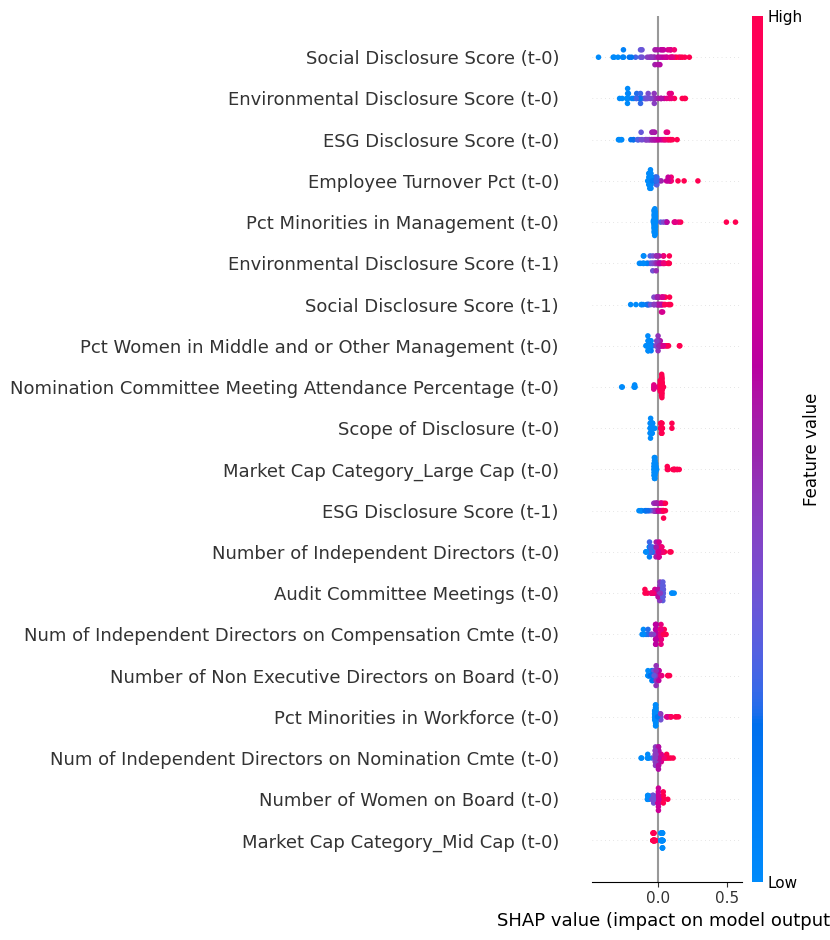

In [32]:
# 6. Plot the summary (beeswarm) plot
shap.summary_plot(shap_values, X_test_flat, feature_names=feature_names)

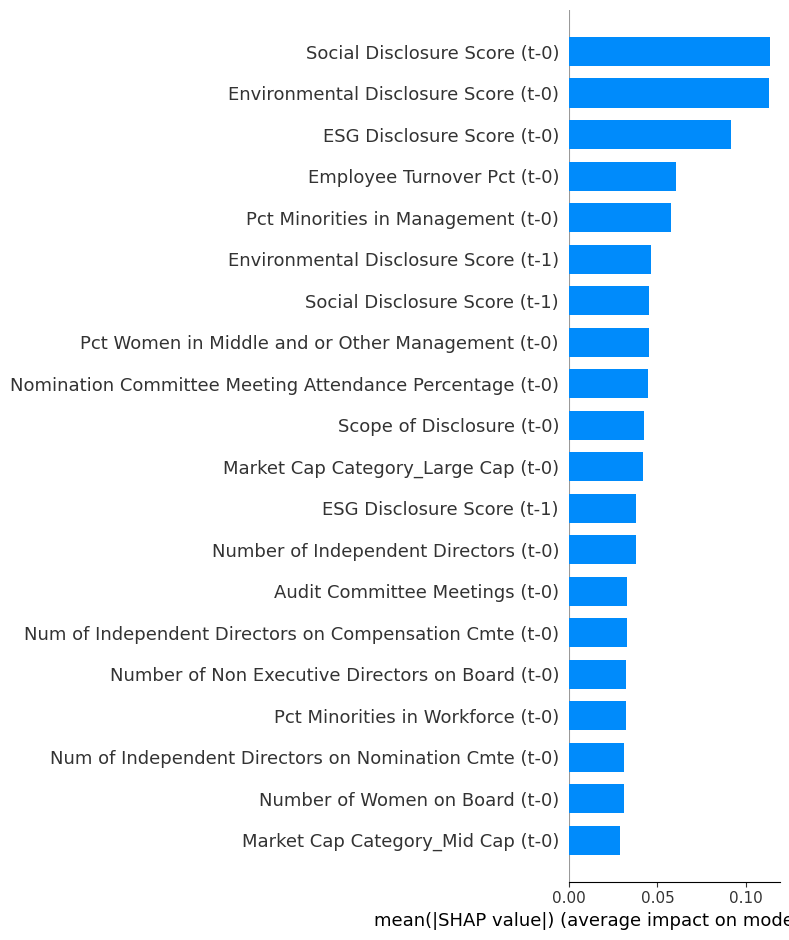

In [36]:
# 7. Bar plot for global feature importance with SHAP scores
shap.summary_plot(shap_values, X_test_flat, feature_names=feature_names, plot_type="bar", show_values_in_legend=True)